In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

In [35]:
import datetime as dt
from datetime import datetime,timedelta
from itertools import chain

# Reflect Tables into SQLAlchemy ORM

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [37]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [38]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [39]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [40]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [41]:
#check columns in each table
inspector = inspect(engine)
columns = inspector.get_columns("measurement")

for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [42]:
#check columns in each table
inspector = inspect(engine)
columns = inspector.get_columns("station")

for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [43]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [44]:
# Calculate the date 1 year ago from the last data point in the database
#need last year before precip data
last_date = (engine.execute("SELECT date FROM measurement ORDER BY date DESC").first())[0]
print(last_date)

year, month, day = map(int, last_date.split("-"))
year_ago = dt.datetime(year, month, day) - timedelta(365)
# year_ago = year_ago.strftime("%Y-%m-%d")
print(year_ago)



2017-08-23
2016-08-23 00:00:00


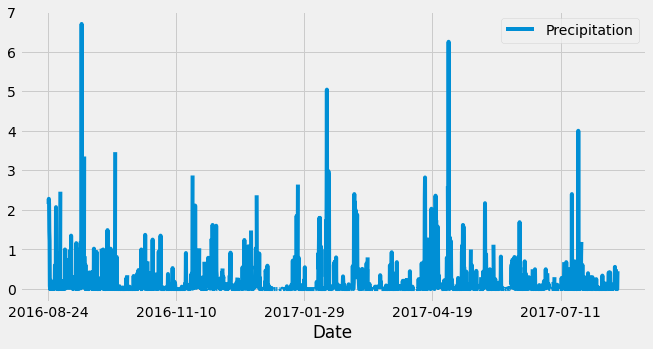

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_year_precip = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago).all()
# print(last_year_precip)
 

# Perform a query to retrieve the data and precipitation scores
date = [row[0] for row in last_year_precip]
precip = [row[1] for row in last_year_precip]

# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame({"Date" : date,
                           "Precipitation" : precip}).set_index("Date")
# climate_df


# Sort the dataframe by date
climate_df = climate_df.sort_values("Date")
# climate_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
climate_df.plot(figsize = (10,5))
plt.xlabel("Date")
# plt.tick_params(
#     axis="x",
#     which="both",
#     labelbottom=False)
plt.legend(loc = "best")
plt.show()


In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [47]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.name)).all()

[(9)]

In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute("SELECT station, count(station) AS count FROM measurement GROUP BY station ORDER BY count desc").fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
engine.execute("SELECT min(tobs), max(tobs), avg(tobs) FROM measurement WHERE station = 'USC00519281'").fetchall()

[(54.0, 85.0, 71.66378066378067)]

In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = engine.execute("SELECT tobs FROM measurement WHERE date >= '2016-8-23' AND station = 'USC00519281'").fetchall()
data = [row[0] for row in data]
hist_data = pd.DataFrame({"tobs": data})
hist_data.head()

,tobs
0,72.0
1,70.0
2,64.0
3,63.0
4,63.0


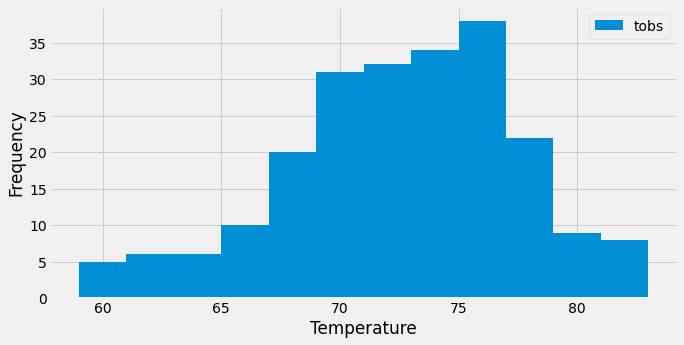

In [51]:
hist = hist_data.hist(bins = 12, figsize = (10, 5))
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("")
plt.legend(["tobs"])
plt.show()

## Bonus Challenge Assignment

In [52]:
#Average June Temps vs Average December Temps
june = "06"
june_temp = session.query(measurement.tobs).filter(func.strftime("%m", measurement.date) == june).all()

dec = "06"
dec_temp = session.query(measurement.tobs).filter(func.strftime("%m", measurement.date) == dec).all()


#ttest
stats.ttest_ind(june_temp, dec_temp, equal_var=False)

Ttest_indResult(statistic=array([0.]), pvalue=array([1.]))

In [53]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [54]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = (calc_temps("2017-08-10", "2017-08-20"))
print(my_trip)

[(70.0, 78.42222222222222, 85.0)]


In [55]:
my_trip_df = pd.DataFrame(my_trip, columns = ["min", "avg", "max"])
my_trip_df

,min,avg,max
0,70.0,78.422222,85.0


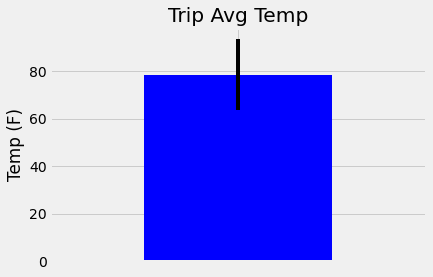

In [56]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = [my_trip_df["max"] - my_trip_df["min"]]
my_trip_df.plot(kind="bar", y="avg", yerr=error, title = "Trip Avg Temp", color="blue", figsize= (6,4), legend="")
plt.ylabel("Temp (F)")
plt.tick_params(
    axis="x",
    which="both",
    labelbottom=False)

In [58]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
engine.execute("SELECT measurement.station, name, latitude, longitude, elevation, sum(prcp) AS total_rainfall \
               FROM measurement \
               JOIN station ON measurement.station == station.station \
               WHERE date BETWEEN '2017-08-10' AND '2017-08-20' \
               GROUP BY measurement.station ORDER BY total_rainfall DESC").fetchall()


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.49),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.51),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.26),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.02)]

In [59]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [62]:
# calculate the daily normals for your trip
# Set the start and end date of the trip
start_date = "2017-08-10"
end_date ="2017-08-20"

# Use the start and end date to create a range of dates
vacay_dates = pd.date_range(start_date, end_date).strftime("%Y-%m-%d")
# vacay_dates

# Stip off the year and save a list of %m-%d strings
vacay_dates = pd.date_range(start_date, end_date).strftime("%m-%d")
vacay_dates



# Loop through the list of %m-%d strings and calculate the normals for each date
# push each tuple of calculations into a list called `normals`
normals = []
for date in vacay_dates:
    normal = daily_normals(date)
    normals.append(normal)
    
normals

[[(65.0, 76.42, 83.0)],
 [(67.0, 75.98113207547169, 82.0)],
 [(67.0, 76.52727272727273, 83.0)],
 [(71.0, 76.98245614035088, 84.0)],
 [(71.0, 76.77777777777777, 82.0)],
 [(69.0, 76.47169811320755, 83.0)],
 [(69.0, 76.08, 83.0)],
 [(69.0, 76.125, 83.0)],
 [(70.0, 76.92307692307692, 84.0)],
 [(69.0, 75.94642857142857, 85.0)],
 [(68.0, 76.45283018867924, 82.0)]]

In [69]:
# Load the previous query results into a Pandas DataFrame and 
new_list = [x for x in chain.from_iterable(normals)]
# new_list

my_trip_df = pd.DataFrame(new_list, columns = ["tmin", "tavg", "tmax"])
# my_trip_df

# add the `trip_dates` range as the `date` index
my_trip_df["date"] = vacay_dates
my_trip_df = my_trip_df.set_index("date")
my_trip_df



,tmin,tavg,tmax
date,,,
08-10,65.0,76.420000,83.0
08-11,67.0,75.981132,82.0
08-12,67.0,76.527273,83.0
08-13,71.0,76.982456,84.0
08-14,71.0,76.777778,82.0
08-15,69.0,76.471698,83.0
08-16,69.0,76.080000,83.0
08-17,69.0,76.125000,83.0
08-18,70.0,76.923077,84.0


(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(-2.0, 0, '08-19'),
  Text(0.0, 0, '08-10'),
  Text(2.0, 0, '08-12'),
  Text(4.0, 0, '08-14'),
  Text(6.0, 0, '08-16'),
  Text(8.0, 0, '08-18'),
  Text(10.0, 0, '08-20'),
  Text(12.0, 0, '')])

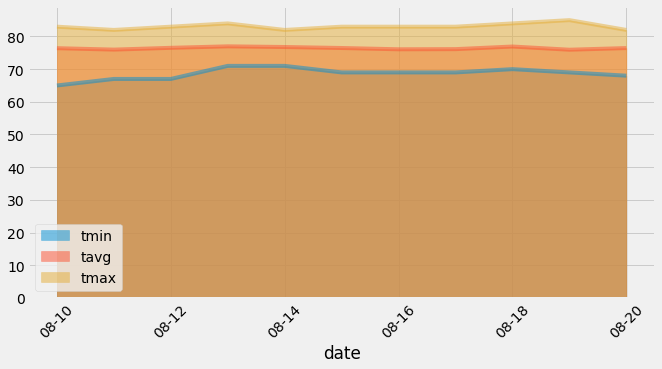

In [72]:
# Plot the daily normals as an area plot with `stacked=False`
my_trip_df.plot(kind = "area", stacked=False, figsize = (10,5))
plt.xticks(rotation= 45)